# Social Network Sentiment Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read Data

In [2]:
data_train = pd.read_csv('./input/train.csv')
data_test = pd.read_csv('./input/test.csv')

In [3]:
data_train.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [4]:
print(data_train.dtypes)
print(data_train.describe())
print(data_train.info())

sentence    object
label        int64
dtype: object
             label
count  5668.000000
mean      0.565279
std       0.495764
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 2 columns):
sentence    5668 non-null object
label       5668 non-null int64
dtypes: int64(1), object(1)
memory usage: 88.6+ KB
None


In [5]:
data_train.label.value_counts()

1    3204
0    2464
Name: label, dtype: int64

In [6]:
print(data_train.shape, data_test.shape)

(5668, 2) (1418, 1)


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

train_vector = vectorizer.fit_transform(data_train.sentence)
test_vector = vectorizer.transform(data_test.sentence)

### Visualize Word Frequency

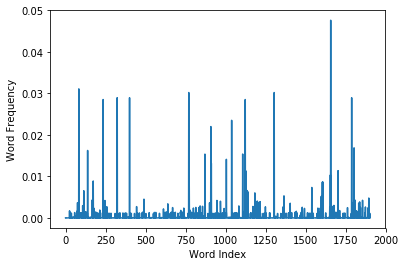

In [8]:
WordFrequency = pd.DataFrame({'Word': vectorizer.get_feature_names(), 'Count': train_vector.toarray().sum(axis=0)})
WordFrequency['Frequency'] = WordFrequency['Count'] / WordFrequency['Count'].sum()

plt.plot(WordFrequency.Frequency)
plt.xlabel('Word Index')
plt.ylabel('Word Frequency')
plt.show()

### Sort WordFrequency in descending order

In [9]:
WordFrequency_sort = WordFrequency.sort_values(by='Frequency', ascending=False)
WordFrequency_sort.head()

,Word,Count,Frequency
1657,the,2656,0.047622
83,and,1734,0.031090
770,harry,1685,0.030212
1304,potter,1685,0.030212
323,code,1616,0.028975


## Model 1: Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

clf_NB = MultinomialNB()

In [11]:
cross_val_NB = cross_val_score(clf_NB, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(cross_val_NB)
print(cross_val_NB.mean())

[0.97007042 0.99119718 0.98591549 0.97183099 0.98233216 0.97349823
 0.97879859 0.98233216 0.97879859 0.9770318 ]
0.9791805603941672


In [12]:
clf_NB.fit(train_vector, data_train.label.values)
predictions = clf_NB.predict(test_vector)

In [13]:
solution_NB = pd.DataFrame(list(zip(data_test.sentence, predictions)), columns=['sentence', 'label'])

solution_NB.to_csv('./solution_naive_bayes.csv', index=False)
# Accuracy in testing data: 0.97461

## Model 2: Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(n_jobs=-1)

In [15]:
cross_val_RF = cross_val_score(clf_RF, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(cross_val_RF)
print(cross_val_RF.mean())

[0.9806338  0.99295775 0.98591549 0.98591549 0.98233216 0.9770318
 0.98233216 0.98939929 0.98409894 0.97879859]
0.9839415468073458


In [16]:
clf_RF.fit(train_vector, data_train.label.values)
prediction_RF = clf_RF.predict(test_vector)

In [17]:
solution_RF = pd.DataFrame(list(zip(data_test.sentence, prediction_RF)), columns=['sentence','label'])

solution_RF.to_csv('./solution_random_forest.csv', index=False)
# Accuracy in testing data: 0.97955

### Use GridSearchCV

In [18]:
from pprint import pprint
from sklearn.model_selection import GridSearchCV

In [19]:
pprint(clf_RF.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [20]:
param_grid = {
             'class_weight': ['balanced', None],
             'criterion': ['gini', 'entropy'],
             'max_depth': [None, 1, 5, 10],
             'max_features': ['auto', 'log2', None],
             'n_estimators': [5, 10, 20]}
cv_clf_RF = GridSearchCV(estimator=clf_RF, param_grid=param_grid, scoring='accuracy', verbose=0, n_jobs=-1)
cv_clf_RF.fit(train_vector, data_train.label.values)
best_parameters = cv_clf_RF.best_params_
print('The best parameters for using RF model is: ', best_parameters)

The best parameters for using RF model is:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 20}


In [21]:
clf_RF_tuned = RandomForestClassifier(n_estimators=20)

In [22]:
RF_score = cross_val_score(clf_RF_tuned, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(RF_score)
print(RF_score.mean())

[0.97887324 0.99295775 0.98767606 0.98943662 0.98056537 0.98056537
 0.98763251 0.98939929 0.98586572 0.98763251]
0.986060443935699


In [23]:
clf_RF_tuned.fit(train_vector, data_train.label.values)
prediction_RF_tuned = clf_RF_tuned.predict(test_vector)
solution_RF_tuned = pd.DataFrame(list(zip(data_test.sentence, prediction_RF_tuned)), columns=['sentence', 'label'])

In [24]:
solution_RF_tuned.to_csv('./solution_RF_tuned.csv', index=False)
# Accuracy in testing data: 0.98660

## Model 3: Logistic Regression (Use GridSearchCV to tune hyper-parameters)

In [25]:
# Use Logistic Regression directly
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression()

In [26]:
cross_val_LR = cross_val_score(clf_LR, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(cross_val_LR)
print(cross_val_LR.mean())

[0.98591549 0.99823944 0.99295775 0.99471831 0.99293286 0.99116608
 0.99116608 0.99293286 0.99469965 0.98763251]
0.992236102125118


### Use GridSearchCV

In [27]:
pprint(clf_LR.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [28]:
param_grid = {'penalty': ['l1', 'l2'],
             'class_weight': ['balanced', None],
             'C': [0.1, 1, 10]
             }
clf_LR2 = GridSearchCV(estimator=clf_LR, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1)
clf_LR2.fit(train_vector, data_train.label.values)
best_param = clf_LR2.best_params_
print('The best parameters for using LR model is: ', best_param)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters for using LR model is:  {'C': 10, 'class_weight': None, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.6s finished


In [29]:
param_grid = {
             'C': [9.5, 10, 10.5]
             }
clf_LR3 = GridSearchCV(estimator=clf_LR, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1)
clf_LR3.fit(train_vector, data_train.label.values)
best_param = clf_LR3.best_params_
print('The best parameters for using LR model is: ', best_param)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
The best parameters for using LR model is:  {'C': 9.5}


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.1s finished


In [30]:
param_grid = {
             'C': [9.3, 9.4, 9.5, 9.6, 9.7]
             }
clf_LR4 = GridSearchCV(estimator=clf_LR, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1)
clf_LR4.fit(train_vector, data_train.label.values)
best_param = clf_LR4.best_params_
print('The best parameters for using LR model is: ', best_param)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
The best parameters for using LR model is:  {'C': 9.4}


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


In [31]:
clf_LR2 = LogisticRegression(C=9.4)
cross_val_LR2 = cross_val_score(clf_LR2, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(cross_val_LR2)
print(cross_val_LR2.mean())

[0.98943662 0.99823944 0.99295775 0.99647887 0.99469965 0.99293286
 0.99116608 0.99293286 0.99293286 0.99116608]
0.9932943064748917


In [32]:
clf_LR.fit(train_vector, data_train.label.values)
clf_LR2.fit(train_vector, data_train.label.values)
prediction_LR1 = clf_LR.predict(test_vector)
prediction_LR2 = clf_LR2.predict(test_vector)

In [33]:
solution_origin_LR = pd.DataFrame(list(zip(data_test.sentence, prediction_LR1)), columns=['sentence', 'label'])
solution_CV_LR = pd.DataFrame(list(zip(data_test.sentence, prediction_LR2)), columns=['sentence', 'label'])

In [34]:
solution_origin_LR.to_csv('./solution_origin_LR.csv', index=False)
# Accuracy in testing data: 0.99083

In [35]:
solution_CV_LR.to_csv('./solution_CV_LR.csv', index=False)
# Accuracy in testing data:0.99083

## Model 4: RNN

In [36]:
import collections
import tensorflow as tf
import os
import nltk
from keras.preprocessing import sequence

/home/ian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [37]:
data_train.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [38]:
num_sentences = len(data_train)
print(num_sentences)

5668


### Applied nltk.word_tokenize to do words spliting

In [39]:
maxLength = 0
word_frequency = collections.Counter()

for idx, row in data_train.iterrows():
    words = nltk.word_tokenize(row['sentence'].lower())
    if len(words) > maxLength:
        maxLength = len(words)
    for word in words:
        word_frequency[word] += 1
print(len(word_frequency))
print(maxLength)

2074
42


In [40]:
maxFeatures = 2074
vocab_size = maxFeatures + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_frequency.most_common(maxLength))}

word2index['PAD'] = 0
word2index['UNK'] = 1
index2word = {i:w for w, i in word2index.items()}

In [41]:
data_X_in = np.empty((num_sentences, ), dtype=list)
data_y = np.zeros((num_sentences, ))
i = 0

for index, row in data_train.iterrows():
    words = nltk.word_tokenize(row['sentence'].lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    data_X_in[i] = seqs
    data_y[i] = int(row['label'])
    i += 1

In [42]:
data_X_in = sequence.pad_sequences(data_X_in, padding='post', value=word2index['PAD'], maxlen=maxLength)

print(data_X_in[:5])
print(data_X_in.shape)

[[ 1 12 13 17  1 18  1 26  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [12 13 19 32 22  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  7  1  1  7  1  5 10  9 11 33  6  6  6  6  6  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  1 25  1  1  5  8 14  1  1 29 27 17  1 22  1  4  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17 24  1  1  3  1  1  8 14  1  1 15  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
(5668, 42)


In [43]:
print(data_y[:5])
print(data_y.shape)

[0. 1. 0. 1. 0.]
(5668,)


In [44]:
def data_generator(batch_size):
    while True:
        for i in range(0,len(data_X_in),batch_size):
            if i + batch_size < len(data_X_in):
                yield data_X_in[i:i + batch_size], data_y[i:i + batch_size]

In [45]:
batch_size = 24
embedding_size = 100
vocab_size = maxFeatures + 2
num_units = 64
NUM_EPOCHS = 10

In [46]:
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Instructions for updating:
Use the retry module or similar alternatives.


In [47]:
with tf.device('/gpu:1'):
    initializer = tf.random_uniform_initializer(
        -0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
    x = tf.placeholder("int32", [None, None])
    y = tf.placeholder("int32", [None])
    x_len = tf.placeholder("int32",[None])
    
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    # embedding
    embedding_encoder = tf.get_variable(
        "embedding_encoder", [vocab_size, embedding_size],dtype=tf.float32)
    encoder_emb_inp = tf.nn.embedding_lookup(
        embedding_encoder, x)
    
    # Build RNN cell
    encoder_cell = tf.contrib.rnn.BasicLSTMCell(num_units)
    
    encoder_cell = tf.contrib.rnn.DropoutWrapper(cell=encoder_cell, output_keep_prob=0.75)
    # Run Dynamic RNN
    #   encoder_outputs: [max_time, batch_size, num_units]
    #   encoder_state: [batch_size, num_units]
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_emb_inp,
        sequence_length=x_len, time_major=False,dtype=tf.float32)
    
    model_logistic = tf.layers.dense(encoder_state[0],1)
    model_pred = tf.nn.sigmoid(model_logistic)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(y,tf.float32),logits=tf.reshape(model_logistic,(-1,)))
    loss = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [48]:
# Refer to open source code in this cell
import sys
import time

class Dataset():
    def __init__(self,data,label):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._data = data
        self._label = label
        assert(data.shape[0] == label.shape[0])
        self._num_examples = data.shape[0]
        pass

    @property
    def data(self):
        return self._data
    
    @property
    def label(self):
        return self._label

    def next_batch(self,batch_size,shuffle = True):
        start = self._index_in_epoch
        if start == 0 and self._epochs_completed == 0:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._data = self.data[idx]  # get list of `num` random samples
            self._label = self.label[idx]

        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            data_rest_part = self.data[start:self._num_examples]
            label_rest_part = self.label[start:self._num_examples]
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._data = self.data[idx0]  # get list of `num` random samples
            self._label = self.label[idx0]

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            data_new_part =  self._data[start:end]  
            label_new_part = self._label[start:end]
            return np.concatenate((data_rest_part, data_new_part), axis=0),np.concatenate((label_rest_part, label_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._data[start:end],self._label[start:end]

class ProgressBar():
    def __init__(self,worksum,info="",auto_display=True):
        self.worksum = worksum
        self.info = info
        self.finishsum = 0
        self.auto_display = auto_display
    def startjob(self):
        self.begin_time = time.time()
    def complete(self,num):
        self.gaptime = time.time() - self.begin_time
        self.finishsum += num
        if self.auto_display == True:
            self.display_progress_bar()
    def display_progress_bar(self):
        percent = self.finishsum * 100 / self.worksum
        eta_time = self.gaptime * 100 / (percent + 0.001) - self.gaptime
        strprogress = "[" + "=" * int(percent // 2) + ">" + "-" * int(50 - percent // 2) + "]"
        str_log = ("%s %.2f %% %s %s/%s \t used:%ds eta:%d s" % (self.info,percent,strprogress,self.finishsum,self.worksum,self.gaptime,eta_time))
        sys.stdout.write('\r' + str_log)

def get_dataset(paths):
    dataset = []
    for path in paths.split(':'):
        path_exp = os.path.expanduser(path)
        classes = os.listdir(path_exp)
        classes.sort()
        nrof_classes = len(classes)
        for i in range(nrof_classes):
            class_name = classes[i]
            facedir = os.path.join(path_exp, class_name)
            if os.path.isdir(facedir):
                images = os.listdir(facedir)
                image_paths = [os.path.join(facedir,img) for img in images]
                dataset.append(ImageClass(class_name, image_paths))
  
    return dataset

class ImageClass():
    "Stores the paths to images for a given class"
    def __init__(self, name, image_paths):
        self.name = name
        self.image_paths = image_paths
  
    def __str__(self):
        return self.name + ', ' + str(len(self.image_paths)) + ' images'
  
    def __len__(self):
        return len(self.image_paths)

def split_dataset(dataset, split_ratio, mode):
    if mode=='SPLIT_CLASSES':
        nrof_classes = len(dataset)
        class_indices = np.arange(nrof_classes)
        np.random.shuffle(class_indices)
        split = int(round(nrof_classes*split_ratio))
        train_set = [dataset[i] for i in class_indices[0:split]]
        test_set = [dataset[i] for i in class_indices[split:-1]]
    elif mode=='SPLIT_IMAGES':
        train_set = []
        test_set = []
        min_nrof_images = 2
        for cls in dataset:
            paths = cls.image_paths
            np.random.shuffle(paths)
            split = int(round(len(paths)*split_ratio))
            if split<min_nrof_images:
                continue  # Not enough images for test set. Skip class...
            train_set.append(ImageClass(cls.name, paths[0:split]))
            test_set.append(ImageClass(cls.name, paths[split:-1]))
    else:
        raise ValueError('Invalid train/test split mode "%s"' % mode)
    return train_set, test_set

In [49]:
session.run(tf.global_variables_initializer())

In [50]:
losses = []
beginning_lr = 0.1
gen = data_generator(batch_size)
for one_epoch in range(0,1):
    pb = ProgressBar(worksum=len(data_X_in))
    pb.startjob()
    for one_batch in range(0,len(data_X_in),batch_size):
        batch_x,batch_y = gen.__next__()
        batch_x_len = np.asarray([len(i) for i in batch_x])
        batch_lr = beginning_lr 
        
        _,batch_loss = session.run([optimizer,loss],feed_dict={
            x:batch_x,
            y:batch_y,
            x_len:batch_x_len,
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch,one_batch,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)

EPOCH 0 batch 5664 lr 0.1 loss 0.19659654796123505 100.35 % [==================================================>] 5688/5668 	 used:28s eta:0 s

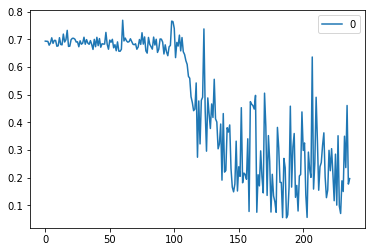

In [51]:
pd.DataFrame(losses).plot()

In [52]:
def predict_result(sent):
    words = nltk.word_tokenize(row['sentence'].lower())
    senttoken = [word2index.get(word,word2index['UNK']) for word in words]
    inputx = np.asarray([senttoken])
    inputx_len = np.asarray([len(senttoken)])
    batch_predict = session.run(model_pred,feed_dict={
            x:inputx,
            x_len:inputx_len,
        })[0]
    return 1 if batch_predict > 0.5 else 0

In [53]:
prediction_RNN = []
for index, row in data_test.iterrows():
    pred = predict_result(row['sentence'])
    prediction_RNN.append(pred)

In [54]:
print(len(prediction_RNN))

1418


In [55]:
solution_RNN = pd.DataFrame(list(zip(data_test.sentence, prediction_RNN)), columns=['sentence', 'label'])

In [57]:
solution_RNN.to_csv('./solution_RNN.csv', index=False)
# Accuracy in testing data: 0.93018
# Because the data set is too small, the performance of RNN model will be worse than basic ML models